In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as td
from scipy.stats import spearmanr
from matplotlib.lines import Line2D
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# FASTA parser requires Biopython
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO
    
# Retrieve protein alignment file
if not os.path.exists('BLAT_ECOLX_1_b0.5_labeled.fasta'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
        
# Retrieve file with experimental measurements
if not os.path.exists('BLAT_ECOLX_Ranganathan2015.csv'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
        
# Options
batch_size = 16

     |████████████████████████████████| 2.3 MB 10.0 MB/s 
--2022-01-13 17:38:10--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2441075 (2.3M)
Saving to: ‘BLAT_ECOLX_1_b0.5_labeled.fasta’

BLAT_ECOLX_1_b0.5_l 100%[===================>]   2.33M  2.21MB/s    in 1.1s    

2022-01-13 17:38:12 (2.21 MB/s) - ‘BLAT_ECOLX_1_b0.5_labeled.fasta’ saved [2441075/2441075]

--2022-01-13 17:38:12--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216640 (1.2M) [text/csv]
Saving to: ‘BLAT_ECOLX_Ranganathan2015.csv’

BLAT_ECOLX_Ranganat 100%[===================>]   1.16M  1.29MB/s 

In [3]:
# Mapping from amino acids to integers
aa1_to_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
                'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
                'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
                'Y': 19, 'X':20, 'Z': 21, '-': 22}
aa1 = "ACDEFGHIKLMNPQRSTVWYXZ-"

phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
         'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
         'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'Other']

def get_data(data_filename, calc_weights=False, weights_similarity_threshold=0.8):
    '''Create dataset from FASTA filename'''
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)       
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
        
        label = label_re.search(record.description).group(1)
        # Only use most common classes
        if label not in phyla:
            label = 'Other'
        labels.append(label)
                
    seqs = torch.from_numpy(np.vstack(seqs).astype(np.float32))
    # seqs = (seqs - torch.min(seqs, dim=0).values) / (torch.max(seqs, dim=0).values - torch.min(seqs, dim=0).values)
    labels = np.array(labels)
    
    phyla_lookup_table, phyla_idx = np.unique(labels, return_inverse=True)

    dataset = torch.utils.data.TensorDataset(*[seqs, torch.from_numpy(phyla_idx)])
    
    weights = None
    if calc_weights is not False:

        # Experiencing memory issues on colab for this code because pytorch doesn't
        # allow one_hot directly to bool. Splitting in two and then merging.
        # one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot1 = F.one_hot(seqs[:len(seqs)//2].long()).bool()
        one_hot2 = F.one_hot(seqs[len(seqs)//2:].long()).bool()
        one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')
        assert(len(seqs) == len(one_hot))
        del one_hot1
        del one_hot2
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)

        weights = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            w = 1.0 / (similarities / lengths).gt(weights_similarity_threshold).sum(1).float()
            weights.append(w)
            
        weights = torch.cat(weights)
        neff = weights.sum()

    return dataset, weights


dataset, weights = get_data('BLAT_ECOLX_1_b0.5_labeled.fasta', calc_weights=True)
sampler = torch.utils.data.WeightedRandomSampler(weights=weights, num_samples=weights.size(dim=0), replacement=True)
dataloader_sampler = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)
dataloader_no_sampler = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
# device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# define the model
class VAE(nn.Module):
    def __init__(self, latent_dim=30, alpha=1e-3):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=263, out_features=1500),
            nn.ReLU(),
            nn.Linear(in_features=1500, out_features=1500),
            nn.ReLU()
        )
        
        self.hidden_mu = nn.Linear(in_features=1500, out_features=latent_dim)
        self.hidden_log_var = nn.Linear(in_features=1500, out_features=latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=2000),
            nn.ReLU(),
            nn.Linear(in_features=2000, out_features=263*23),
            nn.Sigmoid()
        )
        
        self.alpha = alpha
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden)
        return mu, log_var

    def reparameterize(self, mu, std):
        epsilon = torch.randn_like(std)
        return mu + std*epsilon

    def decode(self, zGx):
        xGz = self.decoder(zGx)
        xGz = xGz.view(-1, 263, 23)
        return xGz
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        std = log_var.mul(0.5).exp_()
        zGx = self.reparameterize(mu, std)
        xGz = self.decode(zGx)
        return xGz

    def calculate_loss(self, x, device):
        # encode inputs
        mu, log_var = self.encode(x)
        std = torch.exp(0.5 * log_var)
        # reparameterize
        zGx = self.reparameterize(mu, std)
        xGz = self.decode(zGx)
        # calculate losses
        reconstruction_loss = F.mse_loss(xGz, F.one_hot(x.long(), num_classes=23).float(), reduction='sum')
        kl_divergence = (-0.5*(1 + log_var - mu**2 - torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        vae_loss = self.alpha*reconstruction_loss + kl_divergence
        return vae_loss, self.alpha*reconstruction_loss, kl_divergence

In [6]:
# define the model
class IWAE(nn.Module):
    def __init__(self, latent_dim=30):
        super(IWAE, self).__init__()

        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=263, out_features=1500),
            nn.ReLU(),
            nn.Linear(in_features=1500, out_features=1500),
            nn.ReLU()
        )
        
        self.hidden_mu = nn.Linear(in_features=1500, out_features=latent_dim)
        self.hidden_log_var = nn.Linear(in_features=1500, out_features=latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=2000),
            nn.ReLU(),
            nn.Linear(in_features=2000, out_features=263*23),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden)
        return mu, log_var

    def reparameterize(self, mu, std):
        qzGx = td.Normal(loc=mu, scale=std)
        zGx = qzGx.rsample()
        return zGx, qzGx

    def decode(self, zGx):
        xGz = self.decoder(zGx)
        dim_0, dim_1, _ = xGz.size()
        xGz = xGz.view(dim_0, dim_1, 263, 23)
        return xGz
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        std = log_var.mul(0.5).exp_()
        zGx, _ = self.reparameterize(mu, std)
        xGz = self.decode(zGx)
        return xGz

    def calculate_loss(self, x, beta, device):
        # encode inputs
        mu, log_var = self.encode(x)
        std = torch.exp(0.5 * log_var)
        # reparameterize
        zGx, qzGx = self.reparameterize(mu, std)
        # decode 
        xGz = self.decode(zGx)
        # calculate q(z|x)
        log_qzGx = qzGx.log_prob(zGx)
        log_qzGx = torch.sum(log_qzGx, dim=-1)
        # calculate p(z)
        mu_prior = torch.zeros(self.latent_dim).to(device)
        std_prior = torch.ones(self.latent_dim).to(device)
        pz = td.Normal(loc=mu_prior, scale=std_prior)
        log_pz = torch.sum(pz.log_prob(zGx), dim=-1)
        # calculate p(x|z)
        pxGz = td.categorical.Categorical(logits=xGz).log_prob(x)
        log_pxGz = torch.sum(pxGz, dim=-1)
        # calculate loss
        w = log_pxGz + (log_pz - log_qzGx)*beta
        loss = -torch.mean(torch.logsumexp(w, 0))
        return loss

In [7]:
# train the model
def train_model(model, optimizer, epochs, train_loader, device, num_samples=10, model_type='vae'):
    print('Training the model!\n')
    beta = 0.0
    for epoch in range(epochs):
        # TRAINING
        print('\nEpoch: {}/{}'.format(epoch+1, epochs))
        train_loss = 0.0
        if model_type == 'vae':
            rec_loss, kl_loss = 0.0, 0.0
        for train_data in train_loader:
            train_Xs, _ = train_data
            if model_type == 'iwae':
                dim_0, dim_1 = train_Xs.size()
                train_Xs = train_Xs.expand(num_samples, dim_0, dim_1)
            train_Xs = train_Xs.to(device)
            # forward-propagation
            if model_type == 'vae':
                loss, rec_loss_, kl_loss_ = model.calculate_loss(train_Xs, device=device)
            else:
                loss = model.calculate_loss(train_Xs, beta=beta, device=device)
            # back-propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if model_type == 'vae':
                rec_loss += rec_loss_
                kl_loss += kl_loss_
            if beta < 1.0:
                beta += 0.001
        train_loss /= len(train_loader)
        print('Training Loss: {}'.format(train_loss))
        if model_type == 'vae':
            rec_loss /= len(train_loader)
            print('Reconstruction Loss: {}'.format(rec_loss))
            kl_loss /= len(train_loader)
            print('KL Loss: {}'.format(kl_loss))

    print('\nFinished training the model!')

In [8]:
model_2d_vae_no_sampler = VAE(latent_dim=2, alpha=0.1)
model_2d_vae_no_sampler = model_2d_vae_no_sampler.to(device)
optimizer_2d_vae_no_sampler = torch.optim.Adam(model_2d_vae_no_sampler.parameters(), lr=1e-3)
epochs_2d_vae_no_sampler = 65
train_model(model_2d_vae_no_sampler, optimizer_2d_vae_no_sampler, epochs_2d_vae_no_sampler, dataloader_no_sampler, device, num_samples=None, model_type='vae')

Training the model!


Epoch: 1/65
Training Loss: 260.44919388842925
Reconstruction Loss: 252.31326293945312
KL Loss: 8.13597583770752

Epoch: 2/65
Training Loss: 214.02315406255468
Reconstruction Loss: 208.2046661376953
KL Loss: 5.818485260009766

Epoch: 3/65
Training Loss: 204.37346537292854
Reconstruction Loss: 198.04901123046875
KL Loss: 6.324409008026123

Epoch: 4/65
Training Loss: 200.06455062120364
Reconstruction Loss: 193.62583923339844
KL Loss: 6.438631534576416

Epoch: 5/65
Training Loss: 196.1510162042746
Reconstruction Loss: 189.59988403320312
KL Loss: 6.551151275634766

Epoch: 6/65
Training Loss: 194.4847528647988
Reconstruction Loss: 187.2961883544922
KL Loss: 7.188565731048584

Epoch: 7/65
Training Loss: 188.37535872915853
Reconstruction Loss: 181.34228515625
KL Loss: 7.033177852630615

Epoch: 8/65
Training Loss: 186.56859266976474
Reconstruction Loss: 179.1718292236328
KL Loss: 7.396777629852295

Epoch: 9/65
Training Loss: 182.38446580999494
Reconstruction Loss: 175.0184

In [16]:
model_2d_vae_sampler = VAE(latent_dim=2, alpha=0.1)
model_2d_vae_sampler = model_2d_vae_sampler.to(device)
optimizer_2d_vae_sampler = torch.optim.Adam(model_2d_vae_sampler.parameters(), lr=1e-3)
epochs_2d_vae_sampler = 65
train_model(model_2d_vae_sampler, optimizer_2d_vae_sampler, epochs_2d_vae_sampler, dataloader_sampler, device, num_samples=None, model_type='vae')

Training the model!


Epoch: 1/65
Training Loss: 295.1904155940971
Reconstruction Loss: 284.63922119140625
KL Loss: 10.551375389099121

Epoch: 2/65
Training Loss: 258.9838080707247
Reconstruction Loss: 254.2577362060547
KL Loss: 4.726071834564209

Epoch: 3/65
Training Loss: 254.2874131367794
Reconstruction Loss: 248.9655303955078
KL Loss: 5.321937084197998

Epoch: 4/65
Training Loss: 248.7818993842286
Reconstruction Loss: 243.03384399414062
KL Loss: 5.748071193695068

Epoch: 5/65
Training Loss: 246.11375835908163
Reconstruction Loss: 240.04396057128906
KL Loss: 6.069792747497559

Epoch: 6/65
Training Loss: 241.64806115797242
Reconstruction Loss: 235.3603973388672
KL Loss: 6.28773832321167

Epoch: 7/65
Training Loss: 239.36350966568148
Reconstruction Loss: 232.95408630371094
KL Loss: 6.409429550170898

Epoch: 8/65
Training Loss: 236.49876143539024
Reconstruction Loss: 230.0252685546875
KL Loss: 6.473447799682617

Epoch: 9/65
Training Loss: 234.26848087194253
Reconstruction Loss: 227.738

In [10]:
model_30d_vae_no_sampler = VAE(latent_dim=30, alpha=0.1)
model_30d_vae_no_sampler = model_30d_vae_no_sampler.to(device)
optimizer_30d_vae_no_sampler = torch.optim.Adam(model_30d_vae_no_sampler.parameters(), lr=1e-3)
epochs_30d_vae_no_sampler = 65
train_model(model_30d_vae_no_sampler, optimizer_30d_vae_no_sampler, epochs_30d_vae_no_sampler, dataloader_no_sampler, device, num_samples=None, model_type='vae')

Training the model!


Epoch: 1/65
Training Loss: 260.1601480767586
Reconstruction Loss: 247.34869384765625
KL Loss: 12.81158447265625

Epoch: 2/65
Training Loss: 214.51195972854396
Reconstruction Loss: 203.05201721191406
KL Loss: 11.459945678710938

Epoch: 3/65
Training Loss: 201.39559566707572
Reconstruction Loss: 189.06056213378906
KL Loss: 12.335171699523926

Epoch: 4/65
Training Loss: 191.39660190807584
Reconstruction Loss: 178.65951538085938
KL Loss: 12.737113952636719

Epoch: 5/65
Training Loss: 183.23656988823728
Reconstruction Loss: 169.990478515625
KL Loss: 13.246147155761719

Epoch: 6/65
Training Loss: 176.26478441475365
Reconstruction Loss: 162.8960723876953
KL Loss: 13.368664741516113

Epoch: 7/65
Training Loss: 170.79493935579194
Reconstruction Loss: 157.5092010498047
KL Loss: 13.285745620727539

Epoch: 8/65
Training Loss: 166.72378742039325
Reconstruction Loss: 153.2035369873047
KL Loss: 13.52025318145752

Epoch: 9/65
Training Loss: 161.36642969601508
Reconstruction Loss:

In [11]:
model_30d_vae_sampler = VAE(latent_dim=30, alpha=0.1)
model_30d_vae_sampler = model_30d_vae_sampler.to(device)
optimizer_30d_vae_sampler = torch.optim.Adam(model_30d_vae_sampler.parameters(), lr=1e-3)
epochs_30d_vae_sampler = 65
train_model(model_30d_vae_sampler, optimizer_30d_vae_sampler, epochs_30d_vae_sampler, dataloader_sampler, device, num_samples=None, model_type='vae')

Training the model!


Epoch: 1/65
Training Loss: 295.3595805430364
Reconstruction Loss: 286.4687194824219
KL Loss: 8.890729904174805

Epoch: 2/65
Training Loss: 264.8560955723531
Reconstruction Loss: 257.491455078125
KL Loss: 7.364649772644043

Epoch: 3/65
Training Loss: 252.50517920126984
Reconstruction Loss: 243.59042358398438
KL Loss: 8.914801597595215

Epoch: 4/65
Training Loss: 245.51525965144825
Reconstruction Loss: 235.83096313476562
KL Loss: 9.684351921081543

Epoch: 5/65
Training Loss: 241.9134185697785
Reconstruction Loss: 232.1575927734375
KL Loss: 9.755841255187988

Epoch: 6/65
Training Loss: 236.75105956130017
Reconstruction Loss: 226.76914978027344
KL Loss: 9.982007026672363

Epoch: 7/65
Training Loss: 232.43956842053447
Reconstruction Loss: 222.19952392578125
KL Loss: 10.240072250366211

Epoch: 8/65
Training Loss: 228.75978354086945
Reconstruction Loss: 217.97976684570312
KL Loss: 10.780119895935059

Epoch: 9/65
Training Loss: 224.7988897583878
Reconstruction Loss: 213.5

In [14]:
model_2d_iwae_no_sampler = IWAE(latent_dim=2)
model_2d_iwae_no_sampler = model_2d_iwae_no_sampler.to(device)
optimizer_2d_iwae_no_sampler = torch.optim.Adam(model_2d_iwae_no_sampler.parameters(), lr=1e-3)
epochs_2d_iwae_no_sampler = 65
train_model(model_2d_iwae_no_sampler, optimizer_2d_iwae_no_sampler, epochs_2d_iwae_no_sampler, dataloader_no_sampler, device, model_type='iwae')

Training the model!


Epoch: 1/65
Training Loss: 661.5490491443642

Epoch: 2/65
Training Loss: 654.4837221351514

Epoch: 3/65
Training Loss: 652.5046144318435

Epoch: 4/65
Training Loss: 650.587501044186

Epoch: 5/65
Training Loss: 649.6729991159225

Epoch: 6/65
Training Loss: 648.5233433989546

Epoch: 7/65
Training Loss: 647.3787434067115

Epoch: 8/65
Training Loss: 646.6903294953698

Epoch: 9/65
Training Loss: 646.2070479072524

Epoch: 10/65
Training Loss: 645.9114727944803

Epoch: 11/65
Training Loss: 645.4312643451264

Epoch: 12/65
Training Loss: 645.0960672227039

Epoch: 13/65
Training Loss: 644.5590924731097

Epoch: 14/65
Training Loss: 644.2470355063009

Epoch: 15/65
Training Loss: 643.8792423784369

Epoch: 16/65
Training Loss: 643.8376761939521

Epoch: 17/65
Training Loss: 643.58916490481

Epoch: 18/65
Training Loss: 643.7115572989594

Epoch: 19/65
Training Loss: 642.6952459952981

Epoch: 20/65
Training Loss: 642.6968647321713

Epoch: 21/65
Training Loss: 642.1257659849955

Epo

In [18]:
model_2d_iwae_sampler = IWAE(latent_dim=2)
model_2d_iwae_sampler = model_2d_iwae_sampler.to(device)
optimizer_2d_iwae_sampler = torch.optim.Adam(model_2d_iwae_sampler.parameters(), lr=1e-3)
epochs_2d_iwae_sampler = 65
train_model(model_2d_iwae_sampler, optimizer_2d_iwae_sampler, epochs_2d_iwae_sampler, dataloader_sampler, device, model_type='iwae')

Training the model!


Epoch: 1/65
Training Loss: 673.8934122306995

Epoch: 2/65
Training Loss: 666.9887846968081

Epoch: 3/65
Training Loss: 666.6134893413474

Epoch: 4/65
Training Loss: 664.9177524543343

Epoch: 5/65
Training Loss: 664.3730396651445

Epoch: 6/65
Training Loss: 663.2806389025903

Epoch: 7/65
Training Loss: 663.4915514167118

Epoch: 8/65
Training Loss: 662.5072730039142

Epoch: 9/65
Training Loss: 661.8968141637363

Epoch: 10/65
Training Loss: 661.3795233141866

Epoch: 11/65
Training Loss: 660.9738697432695

Epoch: 12/65
Training Loss: 661.0945128772992

Epoch: 13/65
Training Loss: 660.2048707794997

Epoch: 14/65
Training Loss: 660.4336249512713

Epoch: 15/65
Training Loss: 659.864342839072

Epoch: 16/65
Training Loss: 659.1015723203204

Epoch: 17/65
Training Loss: 659.6167826293199

Epoch: 18/65
Training Loss: 658.6541555369702

Epoch: 19/65
Training Loss: 658.3251024545332

Epoch: 20/65
Training Loss: 658.2045213501225

Epoch: 21/65
Training Loss: 658.2594918991058

E

In [22]:
model_30d_iwae_no_sampler = IWAE(latent_dim=30)
model_30d_iwae_no_sampler = model_30d_iwae_no_sampler.to(device)
optimizer_30d_iwae_no_sampler = torch.optim.Adam(model_30d_iwae_no_sampler.parameters(), lr=1e-3)
epochs_30d_iwae_no_sampler = 65
train_model(model_30d_iwae_no_sampler, optimizer_30d_iwae_no_sampler, epochs_30d_iwae_no_sampler, dataloader_no_sampler, device, model_type='iwae')

Training the model!


Epoch: 1/65
Training Loss: 6.310409110194652e+17

Epoch: 2/65
Training Loss: 652.8571329835476

Epoch: 3/65
Training Loss: 650.1285896378962

Epoch: 4/65
Training Loss: 648.4825910579891

Epoch: 5/65
Training Loss: 647.3283769720198

Epoch: 6/65
Training Loss: 646.5320814952345

Epoch: 7/65
Training Loss: 645.5373865815142

Epoch: 8/65
Training Loss: 644.9368286132812

Epoch: 9/65
Training Loss: 644.5924093397961

Epoch: 10/65
Training Loss: 644.2463311780009

Epoch: 11/65
Training Loss: 643.8828974022642

Epoch: 12/65
Training Loss: 643.0385456279436

Epoch: 13/65
Training Loss: 642.9291381835938

Epoch: 14/65
Training Loss: 642.977128225043

Epoch: 15/65
Training Loss: 642.4697233304958

Epoch: 16/65
Training Loss: 642.1887673185702

Epoch: 17/65
Training Loss: 641.4432963509181

Epoch: 18/65
Training Loss: 641.2796937899774

Epoch: 19/65
Training Loss: 640.6396663378309

Epoch: 20/65
Training Loss: 640.6759766619463

Epoch: 21/65
Training Loss: 640.466683381929

In [24]:
model_30d_iwae_sampler = IWAE(latent_dim=30)
model_30d_iwae_sampler = model_30d_iwae_sampler.to(device)
optimizer_30d_iwae_sampler = torch.optim.Adam(model_30d_iwae_sampler.parameters(), lr=1e-3)
epochs_30d_iwae_sampler = 65
train_model(model_30d_iwae_sampler, optimizer_30d_iwae_sampler, epochs_30d_iwae_sampler, dataloader_sampler, device, model_type='iwae')

Training the model!


Epoch: 1/65
Training Loss: 673.5068133134706

Epoch: 2/65
Training Loss: 666.7631684281919

Epoch: 3/65
Training Loss: 666.0516403415781

Epoch: 4/65
Training Loss: 665.4908448508703

Epoch: 5/65
Training Loss: 664.8231984311354

Epoch: 6/65
Training Loss: 664.0609163179417

Epoch: 7/65
Training Loss: 663.3027356180785

Epoch: 8/65
Training Loss: 663.327737905343

Epoch: 9/65
Training Loss: 662.5259960042483

Epoch: 10/65
Training Loss: 662.8560145857864

Epoch: 11/65
Training Loss: 662.0405509622423

Epoch: 12/65
Training Loss: 661.9129406216189

Epoch: 13/65
Training Loss: 661.8184739868412

Epoch: 14/65
Training Loss: 661.6726443413075

Epoch: 15/65
Training Loss: 661.5128565397864

Epoch: 16/65
Training Loss: 660.9314861103377

Epoch: 17/65
Training Loss: 660.9398296534894

Epoch: 18/65
Training Loss: 660.5809929064966

Epoch: 19/65
Training Loss: 660.0555122826104

Epoch: 20/65
Training Loss: 660.2298541719705

Epoch: 21/65
Training Loss: 660.2410216166386

E

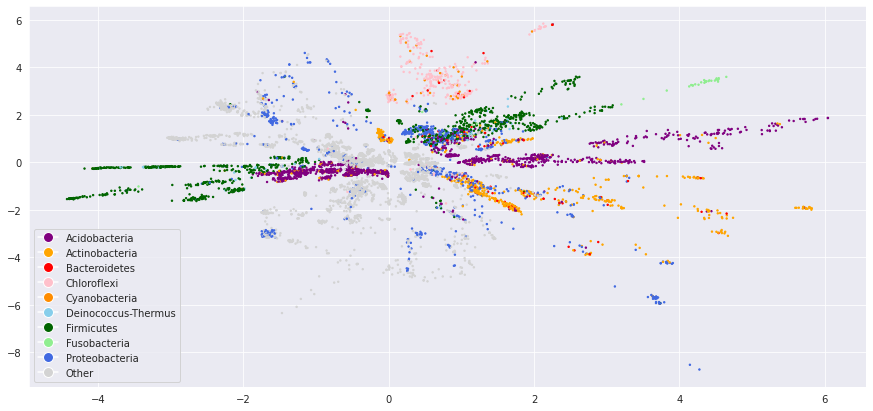

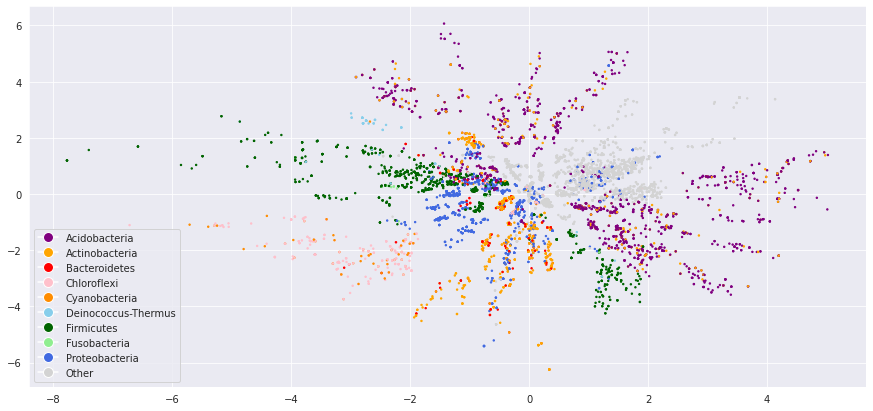

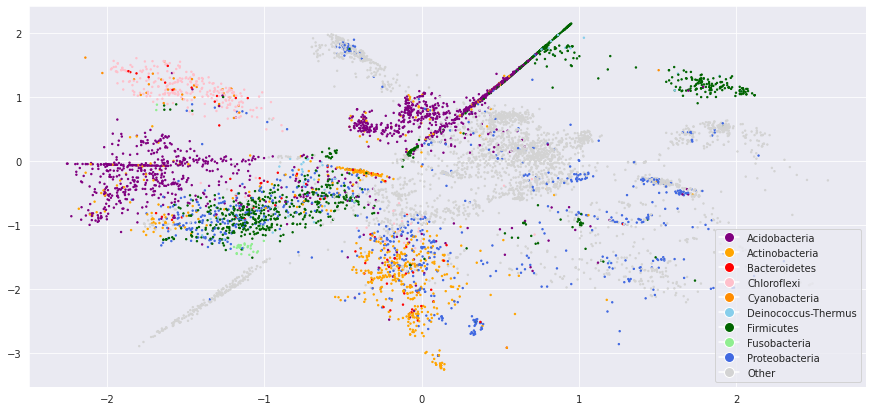

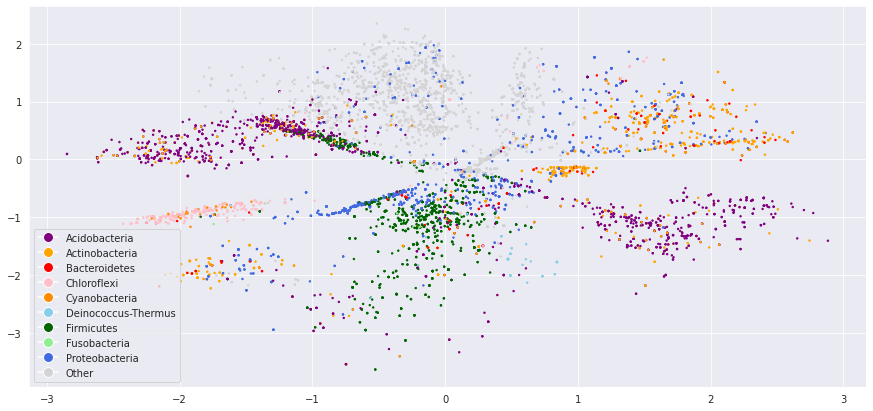

In [19]:
# plot encoded images in 2D and 3D
def plot_encoded_images(model, train_loader, device, dim):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot() if dim == 2 else fig.add_subplot(projection='3d')
    colors = ['purple', 'orange', 'red', 'pink', 'darkorange', 'skyblue', 'darkgreen', 'lightgreen', 'royalblue', 'lightgray']
    colors_map = ListedColormap(['purple', 'orange', 'red', 'pink', 'darkorange', 'skyblue', 'darkgreen', 'lightgreen', 'royalblue', 'lightgray'])
    
    # go through train_data
    for train_data in train_loader:
        train_Xs, train_ys = train_data
        train_Xs = train_Xs.to(device)
        outputs = model.encode(train_Xs)[0]
        outputs = outputs.to('cpu')
        if dim == 2:
            scatter = ax.scatter(outputs[:, 0].detach().numpy(), outputs[:, 1].detach().numpy(), 
                                 c=train_ys.numpy(), cmap=colors_map, s=2)
        else: 
            scatter = ax.scatter(outputs[:, 0].detach().numpy(), outputs[:, 1].detach().numpy(), 
                                 outputs[:, 2].detach().numpy(), c=train_ys.numpy(), cmap=colors_map, s=2)
    
    legend_elements = []
    for i in range(len(phyla)):
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=phyla[i], markerfacecolor=colors[i], markersize=10))

    plt.legend(handles=legend_elements)
    plt.show()

sns.set_style("darkgrid")
plot_encoded_images(model_2d_vae_no_sampler, dataloader_no_sampler, device, dim=2)
plot_encoded_images(model_2d_vae_sampler, dataloader_sampler, device, dim=2)
plot_encoded_images(model_2d_iwae_no_sampler, dataloader_no_sampler, device, dim=2)
plot_encoded_images(model_2d_iwae_sampler, dataloader_sampler, device, dim=2)

In [25]:
def read_experimental_data(filename, alignment_data, measurement_col_name = '2500', sequence_offset=0):
    '''Read experimental data from csv file, and check that amino acid match those 
       in the first sequence of the alignment.
       
       measurement_col_name specifies which column in the csv file contains the experimental 
       observation. In our case, this is the one called 2500.
       
       sequence_offset is used in case there is an overall offset between the
       indices in the two files.
       '''
    
    measurement_df = pd.read_csv(filename, delimiter=',', usecols=['mutant', measurement_col_name])
    
    wt_sequence, wt_label = alignment_data[0]
    
    zero_index = None
    
    experimental_data = {}
    for idx, entry in measurement_df.iterrows():
        mutant_from, position, mutant_to = entry['mutant'][:1],int(entry['mutant'][1:-1]),entry['mutant'][-1:]  
        
        # Use index of first entry as offset (keep track of this in case 
        # there are index gaps in experimental data)
        if zero_index is None:
            zero_index = position
            
        # Corresponding position in our alignment
        seq_position = position-zero_index+sequence_offset
            
        # Make sure that two two inputs agree on the indices: the 
        # amino acids in the first entry of the alignment should be 
        # identical to those in the experimental file.
        # assert mutant_from == aa1[wt_sequence[seq_position]]  
        
        if seq_position not in experimental_data:
            experimental_data[seq_position] = {}
        
        # Check that there is only a single experimental value for mutant
        assert mutant_to not in experimental_data[seq_position]
        
        experimental_data[seq_position]['pos'] = seq_position
        experimental_data[seq_position]['WT'] = mutant_from
        experimental_data[seq_position][mutant_to] = entry[measurement_col_name]
    
    experimental_data = pd.DataFrame(experimental_data).transpose().set_index(['pos', 'WT'])
    return experimental_data
        
        
experimental_data = read_experimental_data("BLAT_ECOLX_Ranganathan2015.csv", dataset)
experimental_data

,,A,C,E,D,G,F,I,K,M,L,N,Q,P,S,R,T,W,V,Y,H
pos,WT,,,,,,,,,,,,,,,,,,,,
0,H,-0.00978356,-0.41826,-0.279024,-0.181607,-0.0602417,-0.818487,-0.359191,0.0144696,-0.224781,-0.480347,-0.0430932,-0.135568,-1.01085,0.0361661,-0.00252626,-0.0671875,-1.34759,-0.026874,-0.885025,NaN
1,P,-1.6426,-0.364138,0.143258,-0.0284025,-0.969268,-0.199804,-0.0735238,0.13559,-0.0283657,-0.211869,0.0206405,-0.0282136,NaN,-0.16013,0.054154,-0.0911999,-0.109139,0.045913,0.00174467,0.0457846
2,E,0.0109131,-0.158233,NaN,-0.0757852,0.0813101,-0.232106,-0.153907,0.0871198,-0.036441,-0.0581804,-0.0064688,0.0496907,-0.387232,-0.0395849,-0.220003,-0.135909,-0.44234,-0.0645674,-0.245436,0.0209168
3,T,-1.45459,-2.41902,-2.41446,-2.29488,-2.35671,-2.60457,-0.280446,-1.42789,-1.8431,-0.765521,-2.48572,-1.6671,-1.79017,-1.39248,-2.37509,NaN,-2.8417,0.0341893,-2.78913,-1.84954
4,L,-0.202228,-1.95959,-1.72164,-2.71077,-1.4842,-0.720047,0.0173958,0.0695957,-0.0480697,NaN,-1.42071,-0.222812,-2.19535,-1.2641,-0.0649357,-0.313656,-0.299738,0.0502655,-0.2186,-0.889277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,L,-0.103001,-0.617685,-2.95432,-2.52951,-2.41565,-0.663794,0.0786722,-2.57103,0.0126656,NaN,-2.32138,-1.72228,-2.42792,-1.65506,-2.70359,-0.231658,-2.78162,-0.0205734,-2.60799,-3.01127
259,I,-0.537631,-0.657012,-2.6017,-2.78886,-2.24781,-0.123746,NaN,-2.24993,-0.0885522,-0.190349,-2.48529,-1.95522,-2.61388,-1.48797,-1.94825,-0.300995,-1.71315,-0.030749,-0.0821665,-2.07812
260,K,-0.0389621,-0.91867,-0.0274808,-0.0614761,-0.0924616,-0.286851,-0.514835,NaN,-0.107796,-0.0442595,-0.0745288,-0.0715558,-2.59327,-0.0202318,-0.04172,-0.090441,-0.449885,-0.261297,-0.111472,-0.00521766


In [29]:
def approximate_log_ratios(experimental_data, model, device, num_samples=10, model_type='vae'):

    experimental_values = np.empty((263, 20))
    approximate_vae_values = np.empty((263, 20))
    
    # compute x_WT
    x_WT = torch.empty(263)
    for (position, mutant_from), _ in experimental_data.iterrows():
        x_WT[position] = aa1_to_index[mutant_from]

    x_WT_ = x_WT.clone()
    
    # get output for x_WT
    x_WT = x_WT[None, :]
    if model_type == 'iwae':
        dim_0, dim_1 = x_WT.size()
        x_WT = x_WT.expand(num_samples, dim_0, dim_1)
    x_WT = x_WT.to(device)
    if model_type == 'vae':
        elbo_WT, _, _ = model.calculate_loss(x_WT, device=device)
    else:
        elbo_WT = model.calculate_loss(x_WT, beta=1.0, device=device)

    # approximate log ratios
    for (position, mutant_from), row in experimental_data.iterrows():
        i = 0
        for mutant_to, exp_value in row.iteritems():
            if not np.isnan(exp_value):
                # compute x_MT
                x_MT = x_WT_.clone()
                x_MT[position] = aa1_to_index[mutant_to]
                # get output for x_MT
                x_MT = x_MT[None, :]
                if model_type == 'iwae':
                    dim_0, dim_1 = x_MT.size()
                    x_MT = x_MT.expand(num_samples, dim_0, dim_1)
                x_MT = x_MT.to(device)
                if model_type == 'vae':
                    elbo_MT, _, _ = model.calculate_loss(x_MT, device=device)
                else:
                    elbo_MT = model.calculate_loss(x_MT, beta=1.0, device=device)
                # compute the approximate log-ratio
                approx_log_ratio = elbo_MT - elbo_WT
                # store values in numpy arrays
                approximate_vae_values[position, i] = approx_log_ratio.item()
                experimental_values[position, i] = exp_value
            else:
                approximate_vae_values[position, i] = 0.0
                experimental_values[position, i] = np.nan
            i += 1

    # compute the Spearman R statistics
    correlation, pvalue = spearmanr(experimental_values.flatten(), approximate_vae_values.flatten(), nan_policy='omit')
    return correlation, pvalue


print(approximate_log_ratios(experimental_data, model_30d_vae_no_sampler, device, model_type='vae'))
print(approximate_log_ratios(experimental_data, model_30d_vae_sampler, device, model_type='vae'))
print(approximate_log_ratios(experimental_data, model_30d_iwae_no_sampler, device, num_samples=10, model_type='iwae'))
print(approximate_log_ratios(experimental_data, model_30d_iwae_sampler, device, num_samples=10, model_type='iwae'))

(0.01355930718413332, 0.3379092957574128)
(0.0009039640837270498, 0.9490619864979435)
(-0.008827968656309252, 0.532693006877258)
(-0.08292692192008205, 4.339420960769493e-09)
